In [1]:
import math
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#define min and max dimension of the matrix
N_max = 4096
N_min = 100

min_index = int(math.log2(N_min))
max_index = int(math.log2(N_max))

#define the range that will be used as input. 
range_dim = np.arange(min_index+1, max_index +1/4 , 1/4)
print(range_dim)
dims = np.int_(2 ** range_dim)
i_max = np.where(dims == np.amax(dims))
i_min = np.where(dims == np.amin(dims))
dims[i_min] = N_min
dims[i_max] = N_max 
print(dims)

[ 7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.    9.25  9.5   9.75
 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75 12.  ]
[ 100  152  181  215  256  304  362  430  512  608  724  861 1024 1217
 1448 1722 2048 2435 2896 3444 4096]


In [3]:
#3darray, which entries correspond to (times in the 3 ways, matrix dimension)
timesarray3d = np.zeros((3, len(dims)))
algorithm = ['usualmat_prod', 'inver_index', 'matmul']

In [4]:
for j, mat_dim in enumerate(dims):
    output = subprocess.run(["./matmul.out"], input="{}, {} \n {}, {} \n".format(mat_dim, mat_dim, mat_dim, mat_dim), 
                    stdout=subprocess.PIPE, encoding="utf-8")
    cpu_3_times = output.stdout.rstrip().split('\n')
        
    # component[0,j], [1,j], [2,j], correspond respectively to: 3loop-for usual matrix product,
    # 3loop-for inverted indices, matmul.
    timesarray3d[0, j] = float(cpu_3_times[0])
    timesarray3d[1, j] = float(cpu_3_times[1])
    timesarray3d[2, j] = float(cpu_3_times[2])

In [5]:
#save in different files the different algorithm's CPU times.
for j, way in enumerate(algorithm):
    f = open(f"./Data/{way}_cputimes.txt", "w")
    data_in = np.column_stack([dims, timesarray3d[j, :]])
    np.savetxt(f , data_in, fmt=['%8i','%15.8f'], delimiter='\t', header = 'Matrix dim. \t Cpu time')
    f.close()

In [27]:
#read the data, so that even if the memory is overwritten/lost data can be analyzed.
data = np.zeros((3, len(dims), 2))
for j, way in enumerate(algorithm):
    data[j] = np.loadtxt(f"./Data/{way}_cputimes.txt") 
    f.close()
data

array([[[1.00000000e+02, 1.20040000e-02],
        [1.52000000e+02, 4.05810000e-02],
        [1.81000000e+02, 4.88800000e-02],
        [2.15000000e+02, 7.27310000e-02],
        [2.56000000e+02, 1.54307990e-01],
        [3.04000000e+02, 2.94870020e-01],
        [3.62000000e+02, 3.82597000e-01],
        [4.30000000e+02, 8.04893970e-01],
        [5.12000000e+02, 1.44282103e+00],
        [6.08000000e+02, 2.02281094e+00],
        [7.24000000e+02, 3.33036113e+00],
        [8.61000000e+02, 6.58262682e+00],
        [1.02400000e+03, 3.12122192e+01],
        [1.21700000e+03, 1.94620190e+01],
        [1.44800000e+03, 3.31626968e+01],
        [1.72200000e+03, 5.73638763e+01],
        [2.04800000e+03, 3.04043823e+02],
        [2.43500000e+03, 1.77424973e+02],
        [2.89600000e+03, 3.19635223e+02],
        [3.44400000e+03, 5.73184753e+02],
        [4.09600000e+03, 2.49808887e+03]],

       [[1.00000000e+02, 8.92000000e-03],
        [1.52000000e+02, 4.00360000e-02],
        [1.81000000e+02, 5.05930

In [32]:
def linear_fit(x_data, y_data):
    def linear_model(x, a, b):
        return a*x + b
    popt, pcov = curve_fit(linear_model, x_data, y_data)
    return popt, pcov

In [33]:
#Fitting with a 1o-polynomial the "Usual way, inverted indices and the matmul version to check the order of scaling"
x_dense = np.log(np.arange(N_min, N_max, 25))

y1_popt, y1_pcov = linear_fit(np.log(dims), np.log(data[0, :, 1])) 
y2_popt, y2_pcov = linear_fit(np.log(dims), np.log(data[1, :, 1]))
y_matmul_popt, y_matmul_pcov = linear_fit(np.log(dims), np.log(data[2, :, 1])) 

y1_fit = y1_popt[0]*x_dense + y1_popt[1]
y1_err = np.sqrt(np.diag(y1_pcov))
y2_fit = y2_popt[0]*x_dense + y2_popt[1]
y2_err = np.sqrt(np.diag(y2_pcov))
y_matmul_fit = y_matmul_popt[0]*x_dense + y_matmul_popt[1]
y_matmul_err = np.sqrt(np.diag(y_matmul_pcov))

print(y1_popt, y1_pcov, y_matmul_popt, y_matmul_pcov)
y1_err


[  3.23197975 -19.74668435] [[ 0.00616749 -0.04053732]
 [-0.04053732  0.27350321]] [  2.76556028 -21.12172072] [[ 0.0025755  -0.01692811]
 [-0.01692811  0.11421311]]


array([0.07853337, 0.52297534])

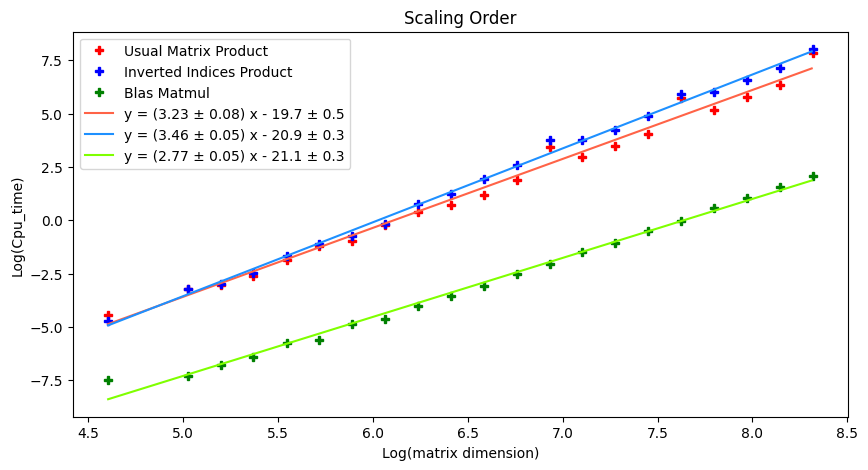

In [34]:
#Plot the logaritmic graph with slope corresponding to the scaling-order related to complexity of the 3 algorithms.   
plt.figure(figsize=(10,5))
plt.xlabel("Log(matrix dimension)")
plt.ylabel("Log(Cpu_time)")
plt.title("Scaling Order")

plt.plot(np.log(dims), np.log(data[0, :, 1]), 'r', marker='P', label = 'Usual Matrix Product', linestyle='None')
plt.plot(np.log(dims), np.log(data[1, :, 1]), 'b', marker='P', label = 'Inverted Indices Product', linestyle='None')
plt.plot(np.log(dims), np.log(data[2, :, 1]), 'g', marker='P', label = 'Blas Matmul', linestyle='None')

plt.plot(x_dense, y1_fit, 'tomato', label= f"y = ({y1_popt[0]:.2f} \u00B1 {y1_err[0]:.2f}) x - {abs(y1_popt[1]):.1f} \u00B1 {y1_err[1]:.1f}")
plt.plot(x_dense, y2_fit, 'dodgerblue', label= f"y = ({y2_popt[0]:.2f} \u00B1 {y2_err[0]:.2f}) x - {abs(y2_popt[1]):.1f} \u00B1 {y2_err[1]:.1f}")
plt.plot(x_dense, y_matmul_fit, 'chartreuse', label= f"y = ({y_matmul_popt[0]:.2f} \u00B1 {y_matmul_err[0]:.2f}) x - {abs(y_matmul_popt[1]):.1f} \u00B1 {y_matmul_err[1]:.1f}")


plt.legend()
plt.savefig('Plots/scaling_order.png')
plt.show()

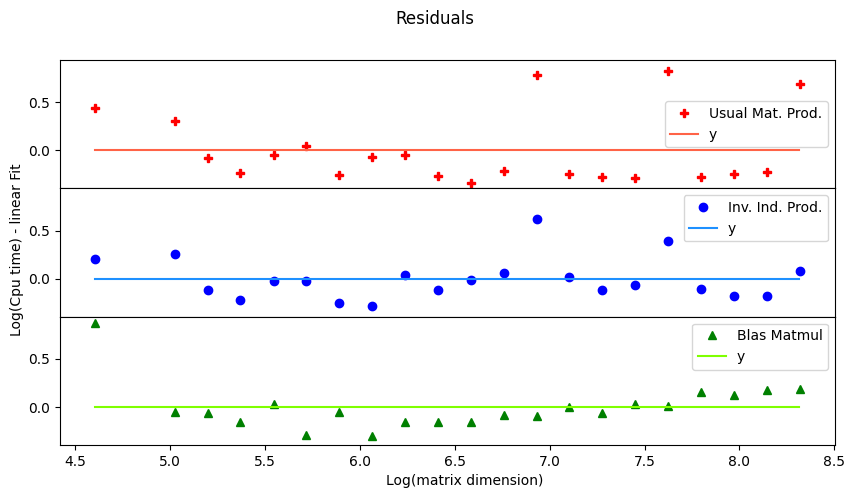

In [77]:
#plot residuals
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Residuals')

y_dense = x_dense * 0
logdim = np.log(dims)
y1 = y1_popt[0] * logdim + y1_popt[1]

y2 = y2_popt[0]* logdim + y2_popt[1]

y_matmul = y_matmul_popt[0]* logdim + y_matmul_popt[1]


axs[0].plot(np.log(dims), np.log(data[0, :, 1]) - y1, 'r', marker='P', label = 'Usual Mat. Prod.', linestyle='None')
axs[1].plot(np.log(dims), np.log(data[1, :, 1]) - y2, 'b', marker='o', label = 'Inv. Ind. Prod.', linestyle='None')
axs[2].plot(np.log(dims), np.log(data[2, :, 1]) - y_matmul, 'g', marker='^', label = 'Blas Matmul', linestyle='None')

axs[0].plot(x_dense, y_dense, 'tomato', label= "y ")
axs[1].plot(x_dense, y_dense, 'dodgerblue', label= "y ")
axs[2].plot(x_dense, y_dense, 'chartreuse', label= "y")

axs[0].legend(loc= 'best')
axs[1].legend()
axs[2].legend()

fig.text(0.53, 0.03, 'Log(matrix dimension)', ha='center')
fig.text(0.075, 0.5, 'Log(Cpu time) - linear Fit', va='center', rotation='vertical')


plt.savefig('Plots/residual_scaling.png')
